In [80]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as dr
import plotly.offline as py
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objs as go
from pandas import Series, DataFrame
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import tree, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import r2_score, precision_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from pmdarima.arima import auto_arima

In [2]:
axis = dr.get_data_yahoo('AXISBANK.NS', start = '2002-8-5',
                       end = '2022-1-1', interval = 'wk')

In [3]:
axis

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-08-04,8.400000,6.900000,8.400000,7.040000,1207175.0,5.712820
2002-08-11,7.300000,6.950000,7.290000,7.000000,561190.0,5.680361
2002-08-18,7.300000,6.930000,7.300000,7.100000,516425.0,5.761509
2002-08-25,7.850000,7.000000,7.180000,7.010000,1895050.0,5.688477
2002-09-01,7.400000,7.010000,7.300000,7.150000,960900.0,5.802083
...,...,...,...,...,...,...
2021-11-28,687.349976,648.000000,665.049988,673.000000,71086971.0,671.977112
2021-12-05,701.549988,661.150024,674.000000,688.049988,47388736.0,687.004272
2021-12-12,721.950012,685.099976,699.000000,688.900024,45093855.0,687.852966


#### LSTM

In [4]:
data = axis.filter(['Close'])
data.head()

,Close
Date,
2002-08-04,7.04
2002-08-11,7.00
2002-08-18,7.10
2002-08-25,7.01
2002-09-01,7.15


In [5]:
ds = data.values

In [6]:
train_len = math.ceil(len(ds)*.7)
train_len

710

In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ds)
scaled_data, scaled_data.shape

(array([[4.94009649e-05],
        [0.00000000e+00],
        [1.23502412e-04],
        ...,
        [8.42163782e-01],
        [8.15734210e-01],
        [8.29381225e-01]]),
 (1013, 1))

In [8]:
train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()
print(len(x_train))
print(len(y_train))

[array([4.94009649e-05, 0.00000000e+00, 1.23502412e-04, 1.23505357e-05,
       1.85253913e-04, 1.85253913e-04, 9.88019297e-05, 2.71705307e-04,
       2.59355360e-04, 2.59355360e-04, 2.71705307e-04, 2.96405789e-04,
       2.71705307e-04, 3.82857772e-04, 2.84055842e-04, 6.66913615e-04,
       8.39816992e-04, 1.08682240e-03, 2.33419824e-03, 2.17364481e-03,
       2.21069524e-03, 1.74138548e-03, 2.30949717e-03, 2.37124867e-03,
       2.35889813e-03, 1.69198452e-03, 1.84018741e-03, 1.08682240e-03,
       2.17364481e-03, 1.97604095e-03, 1.37087766e-03, 1.03742144e-03,
       1.48203012e-03, 1.25972637e-03, 1.34617776e-03, 1.67963398e-03,
       1.79078645e-03, 2.26009620e-03, 2.86525832e-03, 2.42064963e-03,
       2.68000499e-03, 2.88995939e-03, 4.27318758e-03, 3.86562933e-03,
       4.44609155e-03, 3.92738083e-03, 3.40867011e-03, 4.73014680e-03,
       7.43485287e-03, 9.88020240e-03, 1.06953189e-02, 1.11275782e-02,
       1.04853645e-02, 1.00654557e-02, 1.01025073e-02, 9.54674500e-03,
     

In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(650, 60, 1)

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
test_data = scaled_data[train_len-60:, :]
x_test = []
y_test = ds[train_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=100)

Epoch 1/100
65/65 [==============================] - 15s 67ms/step - loss: 0.0076 - val_loss: 367177.8750
Epoch 2/100
65/65 [==============================] - 3s 43ms/step - loss: 0.0011 - val_loss: 367199.0625
Epoch 3/100
65/65 [==============================] - 3s 43ms/step - loss: 0.0011 - val_loss: 367208.3750
Epoch 4/100
65/65 [==============================] - 3s 45ms/step - loss: 8.4568e-04 - val_loss: 367222.3750
Epoch 5/100
65/65 [==============================] - 3s 45ms/step - loss: 8.3942e-04 - val_loss: 367227.2500
Epoch 6/100
65/65 [==============================] - 3s 43ms/step - loss: 7.5768e-04 - val_loss: 367193.4375
Epoch 7/100
65/65 [==============================] - 3s 41ms/step - loss: 8.5815e-04 - val_loss: 367243.5000
Epoch 8/100
65/65 [==============================] - 3s 41ms/step - loss: 7.9229e-04 - val_loss: 367194.6562
Epoch 9/100
65/65 [==============================] - 3s 42ms/step - loss: 8.1781e-04 - val_loss: 367255.3125
Epoch 10/100
65/65 [==========

65/65 [==============================] - 3s 42ms/step - loss: 2.4212e-04 - val_loss: 367202.8125
Epoch 76/100
65/65 [==============================] - 3s 42ms/step - loss: 2.5181e-04 - val_loss: 367197.0625
Epoch 77/100
65/65 [==============================] - 3s 43ms/step - loss: 2.8614e-04 - val_loss: 367177.4375
Epoch 78/100
65/65 [==============================] - 3s 42ms/step - loss: 2.5959e-04 - val_loss: 367164.7812
Epoch 79/100
65/65 [==============================] - 3s 42ms/step - loss: 3.2728e-04 - val_loss: 367157.5312
Epoch 80/100
65/65 [==============================] - 3s 42ms/step - loss: 2.6560e-04 - val_loss: 367171.4062
Epoch 81/100
65/65 [==============================] - 3s 42ms/step - loss: 2.6008e-04 - val_loss: 367200.5625
Epoch 82/100
65/65 [==============================] - 3s 42ms/step - loss: 2.8760e-04 - val_loss: 367221.6250
Epoch 83/100
65/65 [==============================] - 3s 42ms/step - loss: 3.0737e-04 - val_loss: 367179.5938
Epoch 84/100
65/65 [===

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
print(predictions[0:5], y_test[0:5])

[[411.6893 ]
 [435.22595]
 [436.1259 ]
 [449.19492]
 [422.01004]] [[436.1000061]
 [437.5      ]
 [449.8999939]
 [421.6000061]
 [440.5      ]]


In [19]:
mse = np.mean(predictions-y_test)**2
rmse = np.sqrt(np.mean(predictions-y_test)**2)
mse, rmse

(63.937144797770486, 7.9960705848416875)

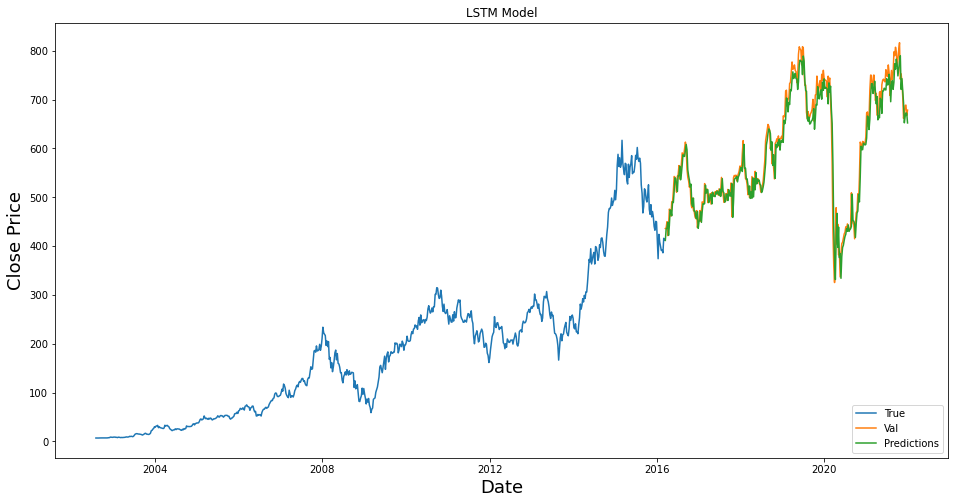

In [20]:
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [21]:
model.save('lstm_model.h5')

#### Prophet:

In [22]:
axisp = axis.reset_index()

In [24]:
df = axisp.filter(['Date', 'Close'])
df

,Date,Close
0,2002-08-04,7.040000
1,2002-08-11,7.000000
2,2002-08-18,7.100000
3,2002-08-25,7.010000
4,2002-09-01,7.150000
...,...,...
1008,2021-11-28,673.000000
1009,2021-12-05,688.049988
1010,2021-12-12,688.900024
1011,2021-12-19,667.500000


In [25]:
df.index[df['Close']<0]

Int64Index([], dtype='int64')

In [26]:
df['Close_shift'] = df['Close'] - df['Close'].shift(1)
y = df['Close_shift']

In [27]:
model1 = Prophet()

In [28]:
df.columns

Index(['Date', 'Close', 'Close_shift'], dtype='object')

In [29]:
df_prpht = df.rename(columns={'Date':'ds','Close_shift':'y'})

In [30]:
df_prpht.head()

,ds,Close,y
0,2002-08-04,7.04,NaN
1,2002-08-11,7.00,-0.04
2,2002-08-18,7.10,0.10
3,2002-08-25,7.01,-0.09
4,2002-09-01,7.15,0.14


In [31]:
train_len1 = int(0.7*len(df))
train_len1

709

In [32]:
df_train = df_prpht[:train_len1]
df_test = df_prpht[train_len1:]
df_train, df_train.shape

(            ds       Close          y
 0   2002-08-04    7.040000        NaN
 1   2002-08-11    7.000000  -0.040000
 2   2002-08-18    7.100000   0.100000
 3   2002-08-25    7.010000  -0.090000
 4   2002-09-01    7.150000   0.140000
 ..         ...         ...        ...
 704 2016-01-31  399.549988  -8.850006
 705 2016-02-07  391.100006  -8.449982
 706 2016-02-14  392.500000   1.399994
 707 2016-02-21  386.350006  -6.149994
 708 2016-02-28  416.049988  29.699982
 
 [709 rows x 3 columns],
 (709, 3))

In [33]:
model1.fit(df_train)

07:11:14 - cmdstanpy - INFO - Chain [1] start processing
07:11:14 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
periods = len(df)-len(df_train)
periods

304

In [35]:
future_dates = model1.make_future_dataframe(periods=periods)

In [36]:
future_dates.shape

(1013, 1)

In [37]:
future_dates.head()

,ds
0,2002-08-04
1,2002-08-11
2,2002-08-18
3,2002-08-25
4,2002-09-01


In [38]:
prediction = model1.predict(future_dates)

In [39]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-08-04,0.353249,-16.908608,12.165315,0.353249,0.353249,-2.477308,-2.477308,-2.477308,-2.477308,-2.477308,-2.477308,0.0,0.0,0.0,-2.124060
1,2002-08-11,0.354162,-18.362339,11.418082,0.354162,0.354162,-4.492255,-4.492255,-4.492255,-4.492255,-4.492255,-4.492255,0.0,0.0,0.0,-4.138093
2,2002-08-18,0.355075,-18.229423,10.532730,0.355075,0.355075,-4.833986,-4.833986,-4.833986,-4.833986,-4.833986,-4.833986,0.0,0.0,0.0,-4.478911
3,2002-08-25,0.355988,-15.532883,12.363763,0.355988,0.355988,-2.240799,-2.240799,-2.240799,-2.240799,-2.240799,-2.240799,0.0,0.0,0.0,-1.884811
4,2002-09-01,0.356901,-12.157453,15.617993,0.356901,0.356901,1.676679,1.676679,1.676679,1.676679,1.676679,1.676679,0.0,0.0,0.0,2.033579


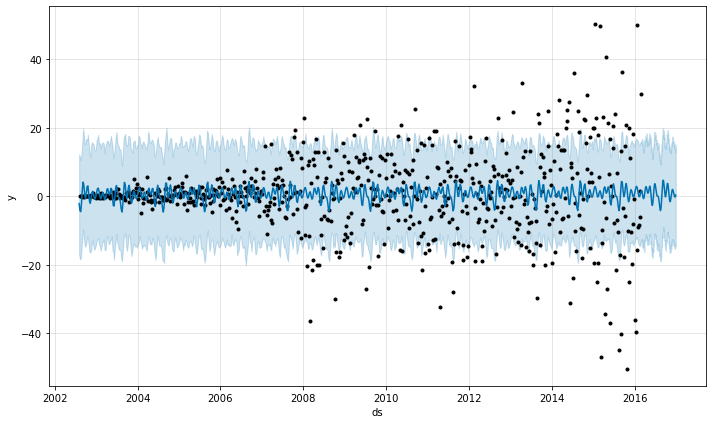

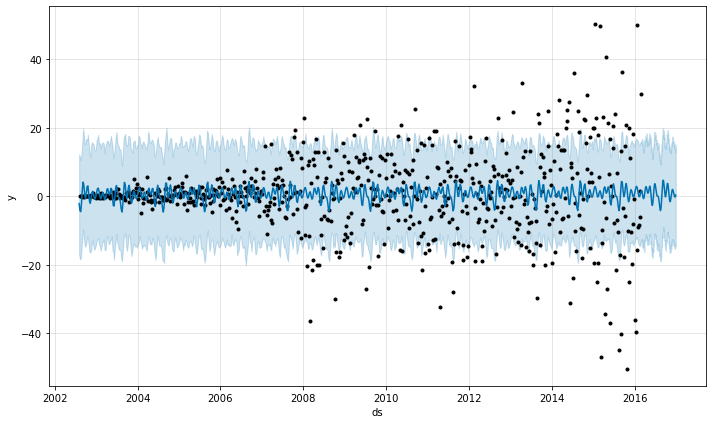

In [40]:
model1.plot(prediction)

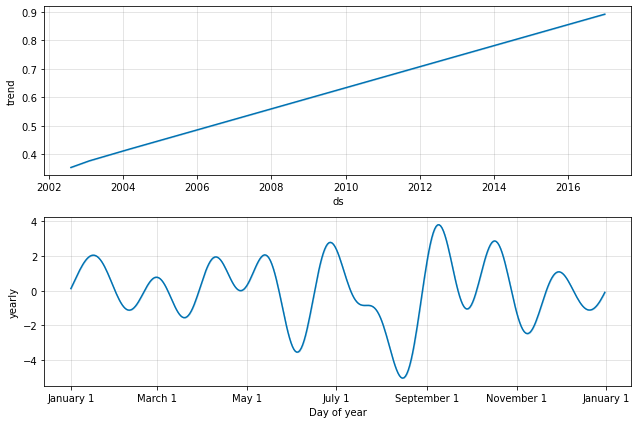

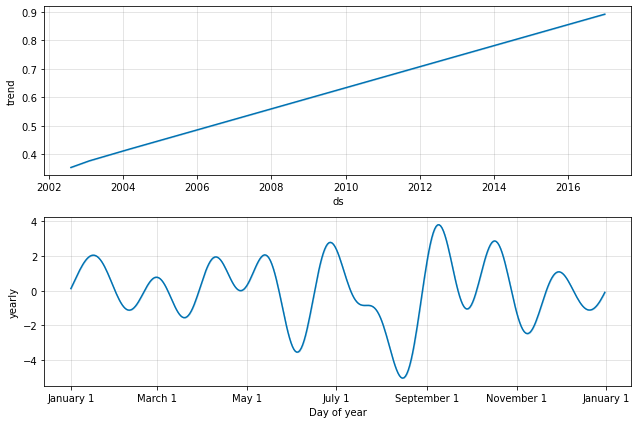

In [41]:
model1.plot_components(prediction)

In [42]:
df_train.shape, len(df)-len(df_train)

((709, 3), 304)

In [43]:
cv = cross_validation(model1, initial='709 days', period='3 days', horizon='304 days')

  0%|          | 0/1313 [00:00<?, ?it/s]

07:14:00 - cmdstanpy - INFO - Chain [1] start processing
07:14:00 - cmdstanpy - INFO - Chain [1] done processing
07:14:01 - cmdstanpy - INFO - Chain [1] start processing
07:14:02 - cmdstanpy - INFO - Chain [1] done processing
07:14:03 - cmdstanpy - INFO - Chain [1] start processing
07:14:03 - cmdstanpy - INFO - Chain [1] done processing
07:14:05 - cmdstanpy - INFO - Chain [1] start processing
07:14:05 - cmdstanpy - INFO - Chain [1] done processing
07:14:07 - cmdstanpy - INFO - Chain [1] start processing
07:14:07 - cmdstanpy - INFO - Chain [1] done processing
07:14:09 - cmdstanpy - INFO - Chain [1] start processing
07:14:09 - cmdstanpy - INFO - Chain [1] done processing
07:14:10 - cmdstanpy - INFO - Chain [1] start processing
07:14:10 - cmdstanpy - INFO - Chain [1] done processing
07:14:12 - cmdstanpy - INFO - Chain [1] start processing
07:14:12 - cmdstanpy - INFO - Chain [1] done processing
07:14:13 - cmdstanpy - INFO - Chain [1] start processing
07:14:13 - cmdstanpy - INFO - Chain [1]

07:16:05 - cmdstanpy - INFO - Chain [1] done processing
07:16:07 - cmdstanpy - INFO - Chain [1] start processing
07:16:07 - cmdstanpy - INFO - Chain [1] done processing
07:16:08 - cmdstanpy - INFO - Chain [1] start processing
07:16:08 - cmdstanpy - INFO - Chain [1] done processing
07:16:10 - cmdstanpy - INFO - Chain [1] start processing
07:16:10 - cmdstanpy - INFO - Chain [1] done processing
07:16:12 - cmdstanpy - INFO - Chain [1] start processing
07:16:12 - cmdstanpy - INFO - Chain [1] done processing
07:16:13 - cmdstanpy - INFO - Chain [1] start processing
07:16:14 - cmdstanpy - INFO - Chain [1] done processing
07:16:15 - cmdstanpy - INFO - Chain [1] start processing
07:16:15 - cmdstanpy - INFO - Chain [1] done processing
07:16:17 - cmdstanpy - INFO - Chain [1] start processing
07:16:17 - cmdstanpy - INFO - Chain [1] done processing
07:16:19 - cmdstanpy - INFO - Chain [1] start processing
07:16:19 - cmdstanpy - INFO - Chain [1] done processing
07:16:21 - cmdstanpy - INFO - Chain [1] 

07:18:13 - cmdstanpy - INFO - Chain [1] done processing
07:18:15 - cmdstanpy - INFO - Chain [1] start processing
07:18:15 - cmdstanpy - INFO - Chain [1] done processing
07:18:17 - cmdstanpy - INFO - Chain [1] start processing
07:18:17 - cmdstanpy - INFO - Chain [1] done processing
07:18:18 - cmdstanpy - INFO - Chain [1] start processing
07:18:19 - cmdstanpy - INFO - Chain [1] done processing
07:18:20 - cmdstanpy - INFO - Chain [1] start processing
07:18:20 - cmdstanpy - INFO - Chain [1] done processing
07:18:22 - cmdstanpy - INFO - Chain [1] start processing
07:18:22 - cmdstanpy - INFO - Chain [1] done processing
07:18:24 - cmdstanpy - INFO - Chain [1] start processing
07:18:24 - cmdstanpy - INFO - Chain [1] done processing
07:18:26 - cmdstanpy - INFO - Chain [1] start processing
07:18:26 - cmdstanpy - INFO - Chain [1] done processing
07:18:28 - cmdstanpy - INFO - Chain [1] start processing
07:18:28 - cmdstanpy - INFO - Chain [1] done processing
07:18:29 - cmdstanpy - INFO - Chain [1] 

07:20:21 - cmdstanpy - INFO - Chain [1] done processing
07:20:22 - cmdstanpy - INFO - Chain [1] start processing
07:20:22 - cmdstanpy - INFO - Chain [1] done processing
07:20:24 - cmdstanpy - INFO - Chain [1] start processing
07:20:24 - cmdstanpy - INFO - Chain [1] done processing
07:20:26 - cmdstanpy - INFO - Chain [1] start processing
07:20:26 - cmdstanpy - INFO - Chain [1] done processing
07:20:28 - cmdstanpy - INFO - Chain [1] start processing
07:20:28 - cmdstanpy - INFO - Chain [1] done processing
07:20:28 - cmdstanpy - INFO - Chain [1] start processing
07:20:28 - cmdstanpy - INFO - Chain [1] done processing
07:20:30 - cmdstanpy - INFO - Chain [1] start processing
07:20:30 - cmdstanpy - INFO - Chain [1] done processing
07:20:32 - cmdstanpy - INFO - Chain [1] start processing
07:20:32 - cmdstanpy - INFO - Chain [1] done processing
07:20:34 - cmdstanpy - INFO - Chain [1] start processing
07:20:34 - cmdstanpy - INFO - Chain [1] done processing
07:20:36 - cmdstanpy - INFO - Chain [1] 

07:22:24 - cmdstanpy - INFO - Chain [1] done processing
07:22:25 - cmdstanpy - INFO - Chain [1] start processing
07:22:25 - cmdstanpy - INFO - Chain [1] done processing
07:22:27 - cmdstanpy - INFO - Chain [1] start processing
07:22:27 - cmdstanpy - INFO - Chain [1] done processing
07:22:29 - cmdstanpy - INFO - Chain [1] start processing
07:22:29 - cmdstanpy - INFO - Chain [1] done processing
07:22:30 - cmdstanpy - INFO - Chain [1] start processing
07:22:30 - cmdstanpy - INFO - Chain [1] done processing
07:22:31 - cmdstanpy - INFO - Chain [1] start processing
07:22:31 - cmdstanpy - INFO - Chain [1] done processing
07:22:33 - cmdstanpy - INFO - Chain [1] start processing
07:22:33 - cmdstanpy - INFO - Chain [1] done processing
07:22:34 - cmdstanpy - INFO - Chain [1] start processing
07:22:34 - cmdstanpy - INFO - Chain [1] done processing
07:22:37 - cmdstanpy - INFO - Chain [1] start processing
07:22:37 - cmdstanpy - INFO - Chain [1] done processing
07:22:38 - cmdstanpy - INFO - Chain [1] 

07:24:27 - cmdstanpy - INFO - Chain [1] done processing
07:24:29 - cmdstanpy - INFO - Chain [1] start processing
07:24:29 - cmdstanpy - INFO - Chain [1] done processing
07:24:29 - cmdstanpy - INFO - Chain [1] start processing
07:24:30 - cmdstanpy - INFO - Chain [1] done processing
07:24:31 - cmdstanpy - INFO - Chain [1] start processing
07:24:31 - cmdstanpy - INFO - Chain [1] done processing
07:24:32 - cmdstanpy - INFO - Chain [1] start processing
07:24:32 - cmdstanpy - INFO - Chain [1] done processing
07:24:33 - cmdstanpy - INFO - Chain [1] start processing
07:24:33 - cmdstanpy - INFO - Chain [1] done processing
07:24:35 - cmdstanpy - INFO - Chain [1] start processing
07:24:35 - cmdstanpy - INFO - Chain [1] done processing
07:24:37 - cmdstanpy - INFO - Chain [1] start processing
07:24:37 - cmdstanpy - INFO - Chain [1] done processing
07:24:38 - cmdstanpy - INFO - Chain [1] start processing
07:24:38 - cmdstanpy - INFO - Chain [1] done processing
07:24:40 - cmdstanpy - INFO - Chain [1] 

07:26:28 - cmdstanpy - INFO - Chain [1] done processing
07:26:29 - cmdstanpy - INFO - Chain [1] start processing
07:26:30 - cmdstanpy - INFO - Chain [1] done processing
07:26:32 - cmdstanpy - INFO - Chain [1] start processing
07:26:32 - cmdstanpy - INFO - Chain [1] done processing
07:26:33 - cmdstanpy - INFO - Chain [1] start processing
07:26:33 - cmdstanpy - INFO - Chain [1] done processing
07:26:35 - cmdstanpy - INFO - Chain [1] start processing
07:26:35 - cmdstanpy - INFO - Chain [1] done processing
07:26:37 - cmdstanpy - INFO - Chain [1] start processing
07:26:37 - cmdstanpy - INFO - Chain [1] done processing
07:26:39 - cmdstanpy - INFO - Chain [1] start processing
07:26:39 - cmdstanpy - INFO - Chain [1] done processing
07:26:41 - cmdstanpy - INFO - Chain [1] start processing
07:26:41 - cmdstanpy - INFO - Chain [1] done processing
07:26:42 - cmdstanpy - INFO - Chain [1] start processing
07:26:42 - cmdstanpy - INFO - Chain [1] done processing
07:26:44 - cmdstanpy - INFO - Chain [1] 

07:28:32 - cmdstanpy - INFO - Chain [1] done processing
07:28:34 - cmdstanpy - INFO - Chain [1] start processing
07:28:34 - cmdstanpy - INFO - Chain [1] done processing
07:28:35 - cmdstanpy - INFO - Chain [1] start processing
07:28:36 - cmdstanpy - INFO - Chain [1] done processing
07:28:37 - cmdstanpy - INFO - Chain [1] start processing
07:28:37 - cmdstanpy - INFO - Chain [1] done processing
07:28:39 - cmdstanpy - INFO - Chain [1] start processing
07:28:39 - cmdstanpy - INFO - Chain [1] done processing
07:28:40 - cmdstanpy - INFO - Chain [1] start processing
07:28:41 - cmdstanpy - INFO - Chain [1] done processing
07:28:42 - cmdstanpy - INFO - Chain [1] start processing
07:28:42 - cmdstanpy - INFO - Chain [1] done processing
07:28:43 - cmdstanpy - INFO - Chain [1] start processing
07:28:44 - cmdstanpy - INFO - Chain [1] done processing
07:28:45 - cmdstanpy - INFO - Chain [1] start processing
07:28:46 - cmdstanpy - INFO - Chain [1] done processing
07:28:48 - cmdstanpy - INFO - Chain [1] 

07:30:43 - cmdstanpy - INFO - Chain [1] done processing
07:30:45 - cmdstanpy - INFO - Chain [1] start processing
07:30:45 - cmdstanpy - INFO - Chain [1] done processing
07:30:47 - cmdstanpy - INFO - Chain [1] start processing
07:30:47 - cmdstanpy - INFO - Chain [1] done processing
07:30:49 - cmdstanpy - INFO - Chain [1] start processing
07:30:49 - cmdstanpy - INFO - Chain [1] done processing
07:30:50 - cmdstanpy - INFO - Chain [1] start processing
07:30:51 - cmdstanpy - INFO - Chain [1] done processing
07:30:53 - cmdstanpy - INFO - Chain [1] start processing
07:30:53 - cmdstanpy - INFO - Chain [1] done processing
07:30:54 - cmdstanpy - INFO - Chain [1] start processing
07:30:55 - cmdstanpy - INFO - Chain [1] done processing
07:30:56 - cmdstanpy - INFO - Chain [1] start processing
07:30:56 - cmdstanpy - INFO - Chain [1] done processing
07:30:58 - cmdstanpy - INFO - Chain [1] start processing
07:30:58 - cmdstanpy - INFO - Chain [1] done processing
07:31:00 - cmdstanpy - INFO - Chain [1] 

07:32:49 - cmdstanpy - INFO - Chain [1] done processing
07:32:50 - cmdstanpy - INFO - Chain [1] start processing
07:32:50 - cmdstanpy - INFO - Chain [1] done processing
07:32:52 - cmdstanpy - INFO - Chain [1] start processing
07:32:52 - cmdstanpy - INFO - Chain [1] done processing
07:32:53 - cmdstanpy - INFO - Chain [1] start processing
07:32:53 - cmdstanpy - INFO - Chain [1] done processing
07:32:55 - cmdstanpy - INFO - Chain [1] start processing
07:32:55 - cmdstanpy - INFO - Chain [1] done processing
07:32:57 - cmdstanpy - INFO - Chain [1] start processing
07:32:57 - cmdstanpy - INFO - Chain [1] done processing
07:32:58 - cmdstanpy - INFO - Chain [1] start processing
07:32:58 - cmdstanpy - INFO - Chain [1] done processing
07:33:00 - cmdstanpy - INFO - Chain [1] start processing
07:33:00 - cmdstanpy - INFO - Chain [1] done processing
07:33:01 - cmdstanpy - INFO - Chain [1] start processing
07:33:02 - cmdstanpy - INFO - Chain [1] done processing
07:33:03 - cmdstanpy - INFO - Chain [1] 

07:35:02 - cmdstanpy - INFO - Chain [1] done processing
07:35:04 - cmdstanpy - INFO - Chain [1] start processing
07:35:04 - cmdstanpy - INFO - Chain [1] done processing
07:35:05 - cmdstanpy - INFO - Chain [1] start processing
07:35:05 - cmdstanpy - INFO - Chain [1] done processing
07:35:07 - cmdstanpy - INFO - Chain [1] start processing
07:35:07 - cmdstanpy - INFO - Chain [1] done processing
07:35:09 - cmdstanpy - INFO - Chain [1] start processing
07:35:09 - cmdstanpy - INFO - Chain [1] done processing
07:35:10 - cmdstanpy - INFO - Chain [1] start processing
07:35:10 - cmdstanpy - INFO - Chain [1] done processing
07:35:12 - cmdstanpy - INFO - Chain [1] start processing
07:35:12 - cmdstanpy - INFO - Chain [1] done processing
07:35:14 - cmdstanpy - INFO - Chain [1] start processing
07:35:14 - cmdstanpy - INFO - Chain [1] done processing
07:35:16 - cmdstanpy - INFO - Chain [1] start processing
07:35:16 - cmdstanpy - INFO - Chain [1] done processing
07:35:18 - cmdstanpy - INFO - Chain [1] 

07:36:49 - cmdstanpy - INFO - Chain [1] done processing
07:36:49 - cmdstanpy - INFO - Chain [1] start processing
07:36:49 - cmdstanpy - INFO - Chain [1] done processing
07:36:50 - cmdstanpy - INFO - Chain [1] start processing
07:36:50 - cmdstanpy - INFO - Chain [1] done processing
07:36:51 - cmdstanpy - INFO - Chain [1] start processing
07:36:51 - cmdstanpy - INFO - Chain [1] done processing
07:36:51 - cmdstanpy - INFO - Chain [1] start processing
07:36:51 - cmdstanpy - INFO - Chain [1] done processing
07:36:52 - cmdstanpy - INFO - Chain [1] start processing
07:36:52 - cmdstanpy - INFO - Chain [1] done processing
07:36:53 - cmdstanpy - INFO - Chain [1] start processing
07:36:53 - cmdstanpy - INFO - Chain [1] done processing
07:36:53 - cmdstanpy - INFO - Chain [1] start processing
07:36:54 - cmdstanpy - INFO - Chain [1] done processing
07:36:54 - cmdstanpy - INFO - Chain [1] start processing
07:36:54 - cmdstanpy - INFO - Chain [1] done processing
07:36:55 - cmdstanpy - INFO - Chain [1] 

07:37:44 - cmdstanpy - INFO - Chain [1] done processing
07:37:45 - cmdstanpy - INFO - Chain [1] start processing
07:37:45 - cmdstanpy - INFO - Chain [1] done processing
07:37:46 - cmdstanpy - INFO - Chain [1] start processing
07:37:46 - cmdstanpy - INFO - Chain [1] done processing
07:37:46 - cmdstanpy - INFO - Chain [1] start processing
07:37:46 - cmdstanpy - INFO - Chain [1] done processing
07:37:47 - cmdstanpy - INFO - Chain [1] start processing
07:37:47 - cmdstanpy - INFO - Chain [1] done processing
07:37:48 - cmdstanpy - INFO - Chain [1] start processing
07:37:48 - cmdstanpy - INFO - Chain [1] done processing
07:37:48 - cmdstanpy - INFO - Chain [1] start processing
07:37:49 - cmdstanpy - INFO - Chain [1] done processing
07:37:49 - cmdstanpy - INFO - Chain [1] start processing
07:37:49 - cmdstanpy - INFO - Chain [1] done processing
07:37:50 - cmdstanpy - INFO - Chain [1] start processing
07:37:50 - cmdstanpy - INFO - Chain [1] done processing
07:37:51 - cmdstanpy - INFO - Chain [1] 

07:38:39 - cmdstanpy - INFO - Chain [1] done processing
07:38:39 - cmdstanpy - INFO - Chain [1] start processing
07:38:39 - cmdstanpy - INFO - Chain [1] done processing
07:38:40 - cmdstanpy - INFO - Chain [1] start processing
07:38:40 - cmdstanpy - INFO - Chain [1] done processing
07:38:40 - cmdstanpy - INFO - Chain [1] start processing
07:38:41 - cmdstanpy - INFO - Chain [1] done processing
07:38:41 - cmdstanpy - INFO - Chain [1] start processing
07:38:41 - cmdstanpy - INFO - Chain [1] done processing
07:38:42 - cmdstanpy - INFO - Chain [1] start processing
07:38:42 - cmdstanpy - INFO - Chain [1] done processing
07:38:42 - cmdstanpy - INFO - Chain [1] start processing
07:38:43 - cmdstanpy - INFO - Chain [1] done processing
07:38:43 - cmdstanpy - INFO - Chain [1] start processing
07:38:43 - cmdstanpy - INFO - Chain [1] done processing
07:38:44 - cmdstanpy - INFO - Chain [1] start processing
07:38:44 - cmdstanpy - INFO - Chain [1] done processing
07:38:44 - cmdstanpy - INFO - Chain [1] 

07:39:27 - cmdstanpy - INFO - Chain [1] done processing
07:39:28 - cmdstanpy - INFO - Chain [1] start processing
07:39:28 - cmdstanpy - INFO - Chain [1] done processing
07:39:29 - cmdstanpy - INFO - Chain [1] start processing
07:39:29 - cmdstanpy - INFO - Chain [1] done processing
07:39:29 - cmdstanpy - INFO - Chain [1] start processing
07:39:29 - cmdstanpy - INFO - Chain [1] done processing
07:39:30 - cmdstanpy - INFO - Chain [1] start processing
07:39:30 - cmdstanpy - INFO - Chain [1] done processing
07:39:31 - cmdstanpy - INFO - Chain [1] start processing
07:39:31 - cmdstanpy - INFO - Chain [1] done processing
07:39:31 - cmdstanpy - INFO - Chain [1] start processing
07:39:31 - cmdstanpy - INFO - Chain [1] done processing
07:39:32 - cmdstanpy - INFO - Chain [1] start processing
07:39:32 - cmdstanpy - INFO - Chain [1] done processing
07:39:32 - cmdstanpy - INFO - Chain [1] start processing
07:39:33 - cmdstanpy - INFO - Chain [1] done processing
07:39:33 - cmdstanpy - INFO - Chain [1] 

07:40:18 - cmdstanpy - INFO - Chain [1] done processing
07:40:19 - cmdstanpy - INFO - Chain [1] start processing
07:40:19 - cmdstanpy - INFO - Chain [1] done processing
07:40:20 - cmdstanpy - INFO - Chain [1] start processing
07:40:20 - cmdstanpy - INFO - Chain [1] done processing
07:40:21 - cmdstanpy - INFO - Chain [1] start processing
07:40:21 - cmdstanpy - INFO - Chain [1] done processing
07:40:21 - cmdstanpy - INFO - Chain [1] start processing
07:40:21 - cmdstanpy - INFO - Chain [1] done processing
07:40:22 - cmdstanpy - INFO - Chain [1] start processing
07:40:22 - cmdstanpy - INFO - Chain [1] done processing
07:40:23 - cmdstanpy - INFO - Chain [1] start processing
07:40:23 - cmdstanpy - INFO - Chain [1] done processing
07:40:23 - cmdstanpy - INFO - Chain [1] start processing
07:40:23 - cmdstanpy - INFO - Chain [1] done processing
07:40:24 - cmdstanpy - INFO - Chain [1] start processing
07:40:24 - cmdstanpy - INFO - Chain [1] done processing
07:40:25 - cmdstanpy - INFO - Chain [1] 

07:41:09 - cmdstanpy - INFO - Chain [1] done processing
07:41:10 - cmdstanpy - INFO - Chain [1] start processing
07:41:10 - cmdstanpy - INFO - Chain [1] done processing
07:41:10 - cmdstanpy - INFO - Chain [1] start processing
07:41:10 - cmdstanpy - INFO - Chain [1] done processing
07:41:11 - cmdstanpy - INFO - Chain [1] start processing
07:41:11 - cmdstanpy - INFO - Chain [1] done processing
07:41:12 - cmdstanpy - INFO - Chain [1] start processing
07:41:12 - cmdstanpy - INFO - Chain [1] done processing
07:41:13 - cmdstanpy - INFO - Chain [1] start processing
07:41:13 - cmdstanpy - INFO - Chain [1] done processing
07:41:13 - cmdstanpy - INFO - Chain [1] start processing
07:41:13 - cmdstanpy - INFO - Chain [1] done processing
07:41:14 - cmdstanpy - INFO - Chain [1] start processing
07:41:14 - cmdstanpy - INFO - Chain [1] done processing
07:41:15 - cmdstanpy - INFO - Chain [1] start processing
07:41:15 - cmdstanpy - INFO - Chain [1] done processing
07:41:15 - cmdstanpy - INFO - Chain [1] 

07:42:01 - cmdstanpy - INFO - Chain [1] done processing
07:42:02 - cmdstanpy - INFO - Chain [1] start processing
07:42:02 - cmdstanpy - INFO - Chain [1] done processing
07:42:03 - cmdstanpy - INFO - Chain [1] start processing
07:42:03 - cmdstanpy - INFO - Chain [1] done processing
07:42:03 - cmdstanpy - INFO - Chain [1] start processing
07:42:03 - cmdstanpy - INFO - Chain [1] done processing
07:42:04 - cmdstanpy - INFO - Chain [1] start processing
07:42:04 - cmdstanpy - INFO - Chain [1] done processing
07:42:05 - cmdstanpy - INFO - Chain [1] start processing
07:42:05 - cmdstanpy - INFO - Chain [1] done processing
07:42:06 - cmdstanpy - INFO - Chain [1] start processing
07:42:06 - cmdstanpy - INFO - Chain [1] done processing
07:42:07 - cmdstanpy - INFO - Chain [1] start processing
07:42:07 - cmdstanpy - INFO - Chain [1] done processing
07:42:07 - cmdstanpy - INFO - Chain [1] start processing
07:42:07 - cmdstanpy - INFO - Chain [1] done processing
07:42:08 - cmdstanpy - INFO - Chain [1] 

In [44]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2004-07-25,0.044527,-1.370839,1.371983,-0.160000,2004-07-20
1,2004-08-01,-0.364883,-1.810847,1.060119,-0.270000,2004-07-20
2,2004-08-08,-0.247989,-1.724861,1.259976,-0.959999,2004-07-20
3,2004-08-15,0.043753,-1.497394,1.461861,-1.220001,2004-07-20
4,2004-08-22,0.049770,-1.372008,1.577395,-0.309999,2004-07-20


In [45]:
cv.shape

(57022, 6)

In [46]:
df_train_pm = performance_metrics(cv)

In [47]:
df_train_pm

,horizon,mse,rmse,mae,mdape,smape,coverage
0,31 days,133.274465,11.544456,8.210968,1.012706,1.638149,0.534617
1,32 days,133.121646,11.537835,8.213543,1.012618,1.638096,0.534776
2,33 days,133.517354,11.554971,8.221690,1.012618,1.638494,0.533899
3,34 days,133.535889,11.555773,8.223133,1.012618,1.639239,0.533703
4,35 days,133.383069,11.549159,8.225708,1.011919,1.639186,0.533548
...,...,...,...,...,...,...,...
269,300 days,170.225475,13.047049,9.375162,1.003934,1.664918,0.471244
270,301 days,170.332517,13.051150,9.377316,1.003861,1.665391,0.470871
271,302 days,169.827973,13.031806,9.370219,1.003934,1.664785,0.470604
272,303 days,170.236227,13.047461,9.378845,1.004107,1.665491,0.469992


In [48]:
MSE = sum(df_train_pm['mse'])/len(df_train_pm)
RMSE = sum(df_train_pm['rmse'])/len(df_train_pm)
MSE, RMSE

(149.61454600831914, 12.223000450817256)

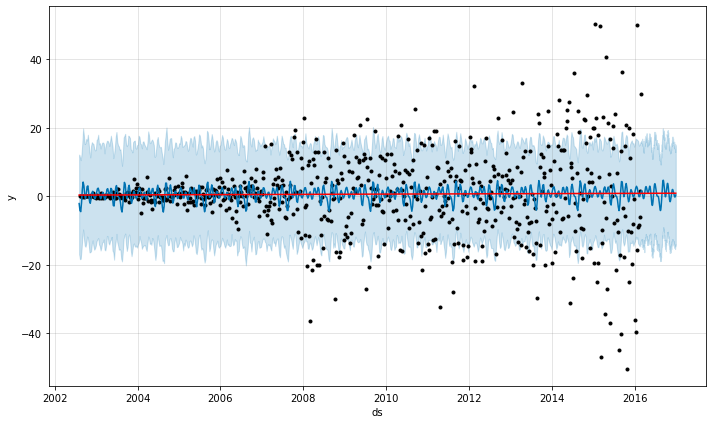

In [49]:
fig = model1.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model1, prediction)

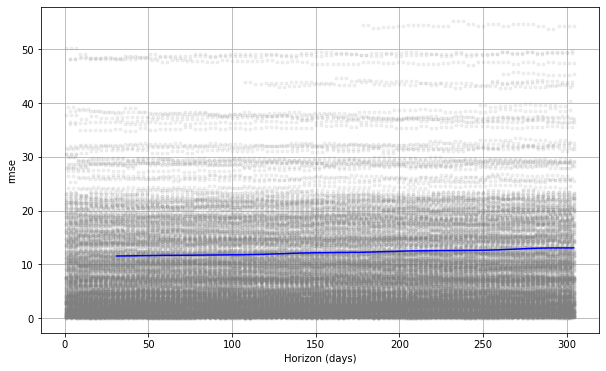

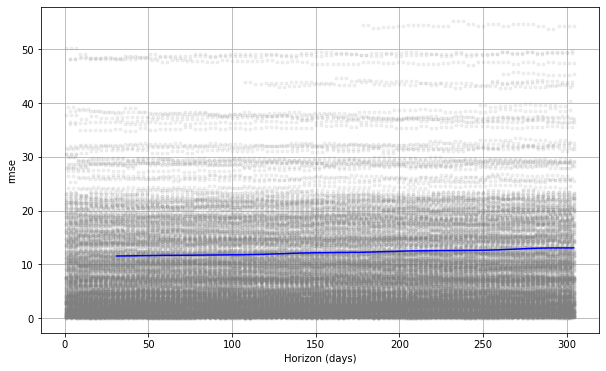

In [50]:
plot_cross_validation_metric(cv, metric='rmse')

#### ARIMA

In [51]:
model2 = pm.auto_arima(df_train['Close'], start_p=1, start_q=1, test='adf',
                      max_p=3, max_q=3, m=1, d=None, seasonal=False, start_P=0,
                      D=0, trace=True, error_action='ignore', suppress_warnings=True,
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5480.113, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5480.638, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5479.433, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5479.117, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5480.399, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5479.935, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5481.813, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5479.155, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.156 seconds


In [54]:
model2 = ARIMA(df_train['Close'], order=(0,1,1))
model2_fit = model2.fit()

In [55]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  709
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2737.578
Date:                Fri, 04 Nov 2022   AIC                           5479.155
Time:                        07:45:57   BIC                           5488.280
Sample:                             0   HQIC                          5482.680
                                - 709                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0711      0.024     -3.017      0.003      -0.117      -0.025
sigma2       133.6686      4.464     29.943      0.000     124.919     142.418
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               289.26
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              42.70   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
data = axis.sort_index(ascending=True, axis=0)

In [58]:
train = data[:709]
valid = data[709:]

In [59]:
training = train['Close']
validation = train['Close']

In [60]:
model_ar = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                     start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                     suppress_warnings=True)
model_ar.fit(training)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5921.686, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5662.052, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5907.963, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5523.351, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5523.101, Time=0.53 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5668.079, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.86 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5523.081, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5661.016, Time=0.35 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, T

ARIMA(order=(3, 1, 3), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [61]:
forecast = model_ar.predict(n_periods=304)
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Prediction'])

In [62]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

884.7196676578812

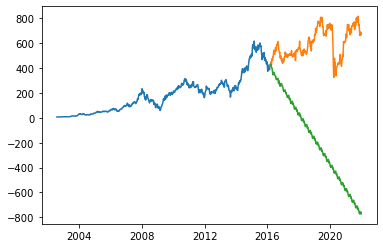

In [63]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

#### Moving Average

In [67]:
data = axisp.sort_index(ascending=True, axis=0)

In [68]:
new_data = pd.DataFrame(index=range(0, len(axisp)), columns=['Date', 'Close'])

In [69]:
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
train = new_data[:709]
valid = new_data[709:]

In [70]:
train.shape, valid.shape

((709, 2), (304, 2))

In [71]:
preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train)-190+i:].sum() + sum(preds)
    b = a/190
    preds.append(b)

rmse = np.sqrt(np.mean(np.array(np.power((valid['Close'])-preds,2))))
rmse

168.8667192512998

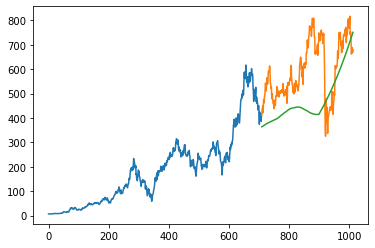

In [72]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

#### KNN Model

In [73]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [74]:
new_data = pd.DataFrame(axis, columns=['Open', 'High', 'Low', 'Close'])
train = new_data[:709]
valid = new_data[709:]

In [75]:
x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [76]:
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

In [81]:
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model_knn = GridSearchCV(knn, params, cv = 5)

In [82]:
model_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]})

In [83]:
pred = model_knn.predict(x_valid)

In [84]:
rmse_knn = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(pred)),2)))
rmse_knn

265.2282378260916

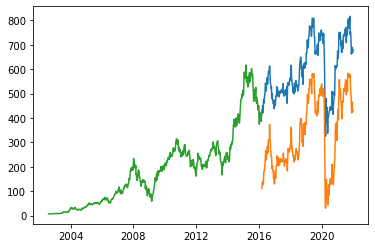

In [85]:
valid['Predictions'] = 0
valid['Predictions'] = pred
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])